In [ ]:
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, LeakyReLU

# Load the CIFAR-100 dataset
# Each image is 32x32x3 and there are 100 classes
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

# Normalize the images to range between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Combine the original training and test sets into a single dataset of 60,000 images
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Shuffle the entire dataset
shuffle_indices = np.random.permutation(len(all_images))
shuffled_images = all_images[shuffle_indices]
shuffled_labels = all_labels[shuffle_indices]

# Split into 50,000 images for the new training set and 10,000 for the new test set
train_images = shuffled_images[:50000]
train_labels = shuffled_labels[:50000]
test_images = shuffled_images[50000:]
test_labels = shuffled_labels[50000:]

# Introduce 10,000 images from the training set into the test set to simulate a membership inference scenario
num_train_in_test = 10000
train_indices_for_test = np.random.permutation(len(train_images))[:num_train_in_test]

# Extract these images and labels
train_images_for_test = train_images[train_indices_for_test]
train_labels_for_test = train_labels[train_indices_for_test]

# Add them to the test set
combined_test_images = np.concatenate((test_images, train_images_for_test), axis=0)
combined_test_labels = np.concatenate((test_labels, train_labels_for_test), axis=0)

# Create a membership flag: 1 for images originally from the training set, 0 otherwise
membership_flag = np.concatenate((np.zeros(len(test_images)), np.ones(num_train_in_test)))

# Reshape labels if necessary
train_labels = train_labels.reshape(-1)
combined_test_labels = combined_test_labels.reshape(-1)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 100)
combined_test_labels = to_categorical(combined_test_labels, 100)

# Define the model
from tensorflow.keras.layers import Dropout, LeakyReLU

model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(LeakyReLU(alpha=0.3))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(LeakyReLU(alpha=0.3))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(LeakyReLU(alpha=0.3))

model.add(layers.Flatten())

# Fully connected layers with dropout
model.add(layers.Dense(256))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))

model.add(layers.Dense(128))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))

model.add(layers.Dense(64))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))

model.add(layers.Dense(100, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Adjusted early stopping and batch size
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    epochs=100,
                    batch_size=128,
                    validation_data=(combined_test_images, combined_test_labels),
                    callbacks=[early_stopping])


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0282 - loss: 4.4614 - val_accuracy: 0.1275 - val_loss: 3.8040
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1054 - loss: 3.8285 - val_accuracy: 0.1893 - val_loss: 3.4217
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1528 - loss: 3.5192 - val_accuracy: 0.2412 - val_loss: 3.1123
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1956 - loss: 3.2781 - val_accuracy: 0.2758 - val_loss: 2.9052
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2291 - loss: 3.0935 - val_accuracy: 0.3067 - val_loss: 2.7383
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2466 - loss: 2.9762 - val_accuracy: 0.3280 - val_loss: 2.6211
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2765 - loss: 2.8504 - val_accuracy: 0.3422 - val_loss: 2.5709
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2896 - loss: 2.7546 - val_a

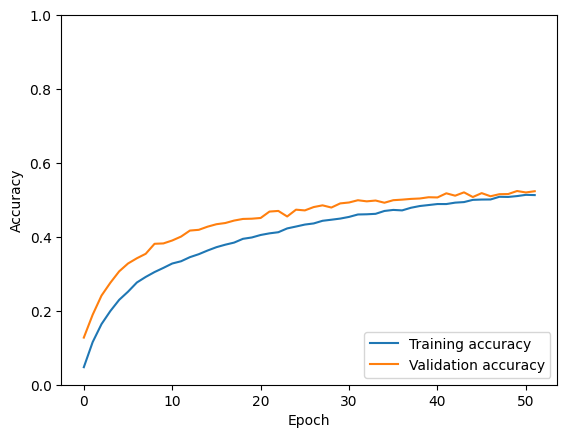

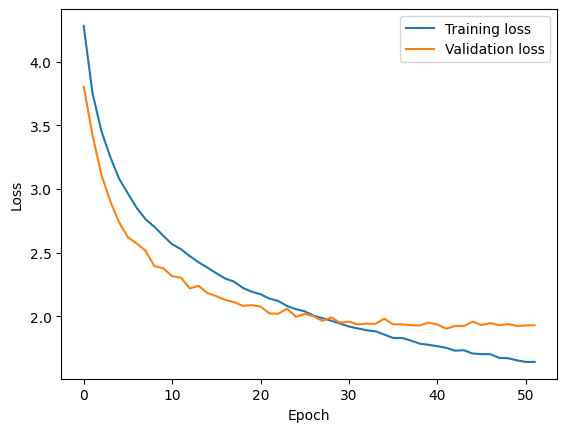

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Predict probabilities for the combined test set
probabilities = model.predict(combined_test_images)

# Get the predicted class and the most confident percentage for each input
predicted_classes = np.argmax(probabilities, axis=1)
max_confidences = np.max(probabilities, axis=1) * 100  # Convert to percentage

# Print the average confidence to get a sense of the results
print(f"Average confidence: {np.mean(max_confidences):.2f}%")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Average confidence: 50.28%


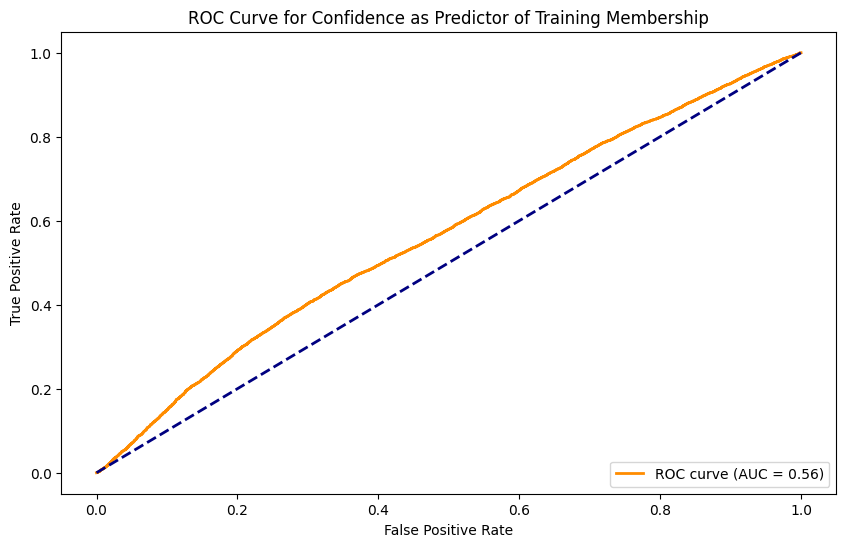

Threshold closest to 99% confidence: 60.01
True Positive Rate (TPR) at 99% confidence threshold: 0.40
False Positive Rate (FPR) at 99% confidence threshold: 0.29


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `max_confidences` is the array of confidence scores for each data point
# And `membership_flag` is the array with 1 for training data, 0 for non-training data

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(membership_flag, max_confidences)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Confidence as Predictor of Training Membership')
plt.legend(loc="lower right")
plt.show()

# Find the threshold closest to 99% confidence
closest_index = (np.abs(thresholds - 60)).argmin()  # Adjust if `max_confidences` are in raw probability form (0-1)
print(f"Threshold closest to 99% confidence: {thresholds[closest_index]:.2f}")
print(f"True Positive Rate (TPR) at 99% confidence threshold: {tpr[closest_index]:.2f}")
print(f"False Positive Rate (FPR) at 99% confidence threshold: {fpr[closest_index]:.2f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


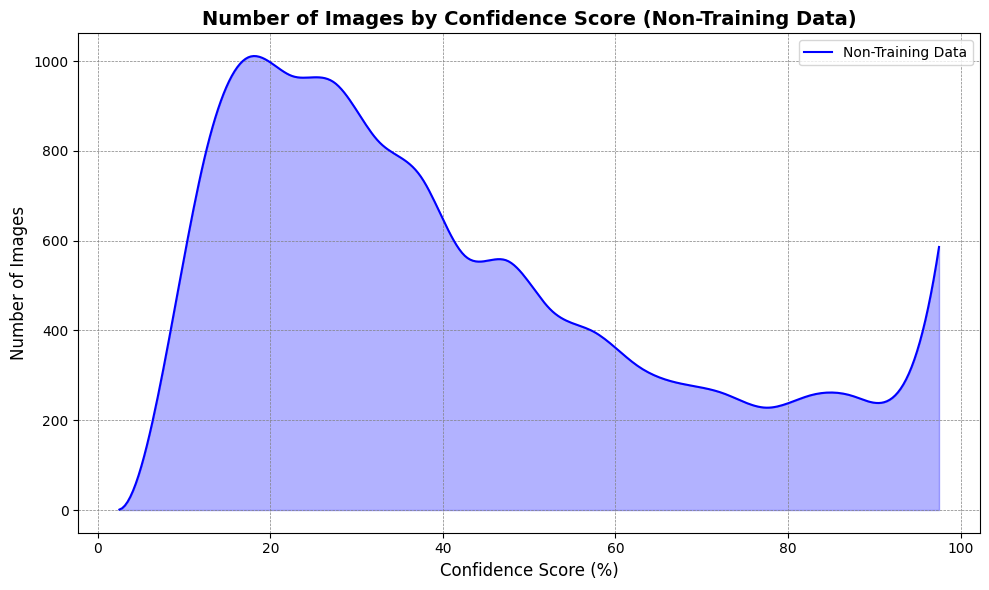

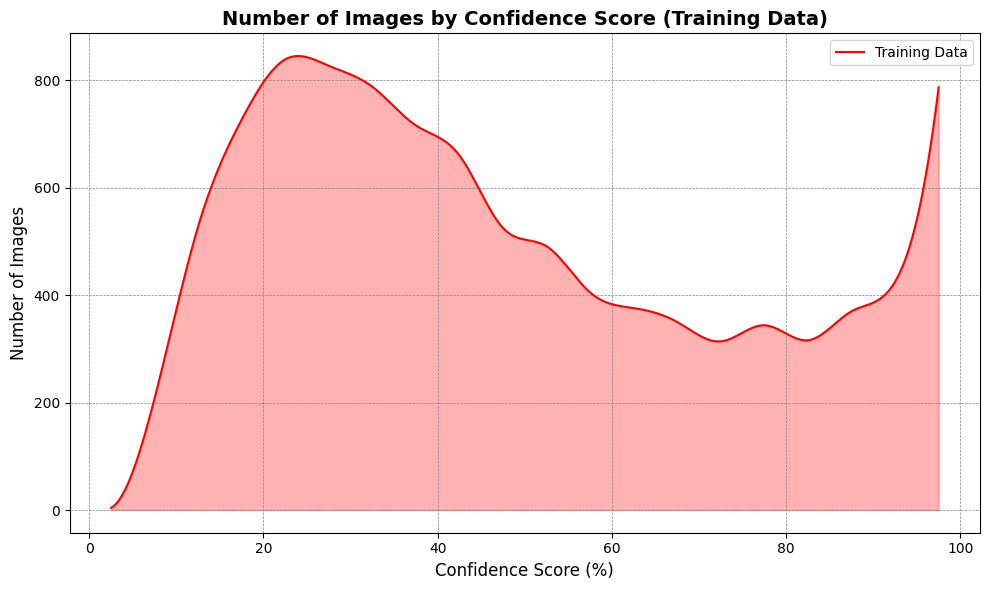

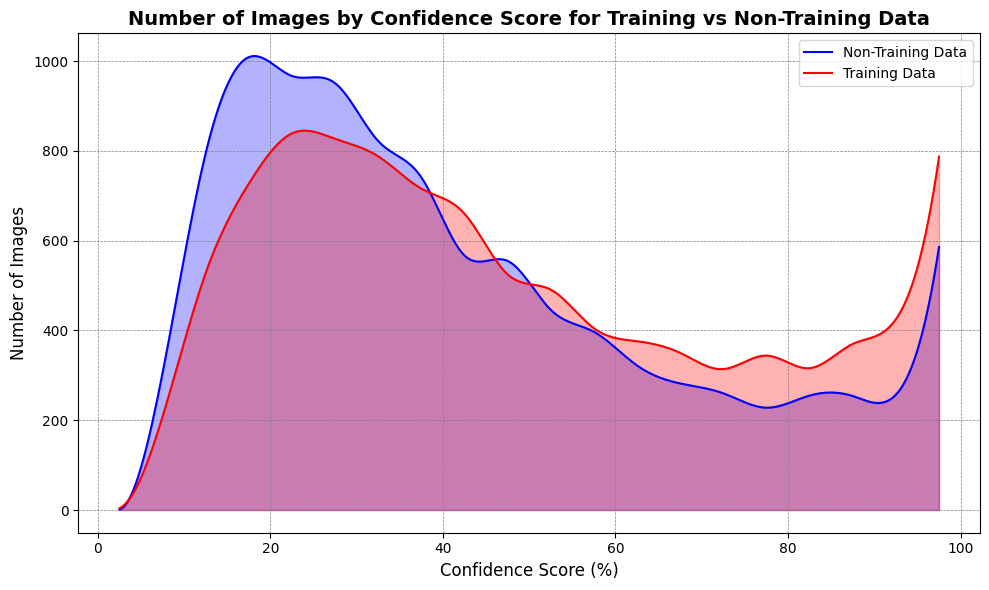

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Predict probabilities for each class in the combined test set
probabilities = model.predict(combined_test_images)

# Get the highest confidence score for each image
max_confidences = np.max(probabilities, axis=1) * 100  # Convert to percentage

# Separate confidence scores based on membership flag
training_confidences = max_confidences[membership_flag == 1]
non_training_confidences = max_confidences[membership_flag == 0]

# Define confidence bins for the x-axis
confidence_bins = np.arange(0, 101, 5)  # Bins from 0 to 100% in steps of 5%

# Calculate histogram (count) of confidence scores for each group
training_counts, _ = np.histogram(training_confidences, bins=confidence_bins)
non_training_counts, _ = np.histogram(non_training_confidences, bins=confidence_bins)

# Smooth the lines using spline interpolation
x_vals = confidence_bins[:-1] + 2.5  # Center points within each bin
x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)  # More points for smoothness

# Spline for non-training data
non_training_spline = make_interp_spline(x_vals, non_training_counts, k=3)
non_training_smooth = non_training_spline(x_smooth)

# Spline for training data
training_spline = make_interp_spline(x_vals, training_counts, k=3)
training_smooth = training_spline(x_smooth)

# Plot 1: Non-Training Data Only
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, non_training_smooth, color='blue', label='Non-Training Data')
plt.fill_between(x_smooth, non_training_smooth, color='blue', alpha=0.3)
plt.xlabel('Confidence Score (%)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images by Confidence Score (Non-Training Data)', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

# Plot 2: Training Data Only
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, training_smooth, color='red', label='Training Data')
plt.fill_between(x_smooth, training_smooth, color='red', alpha=0.3)
plt.xlabel('Confidence Score (%)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images by Confidence Score (Training Data)', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

# Plot 3: Combined Graph
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, non_training_smooth, color='blue', label='Non-Training Data')
plt.fill_between(x_smooth, non_training_smooth, color='blue', alpha=0.3)
plt.plot(x_smooth, training_smooth, color='red', label='Training Data')
plt.fill_between(x_smooth, training_smooth, color='red', alpha=0.3)
plt.xlabel('Confidence Score (%)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images by Confidence Score for Training vs Non-Training Data', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


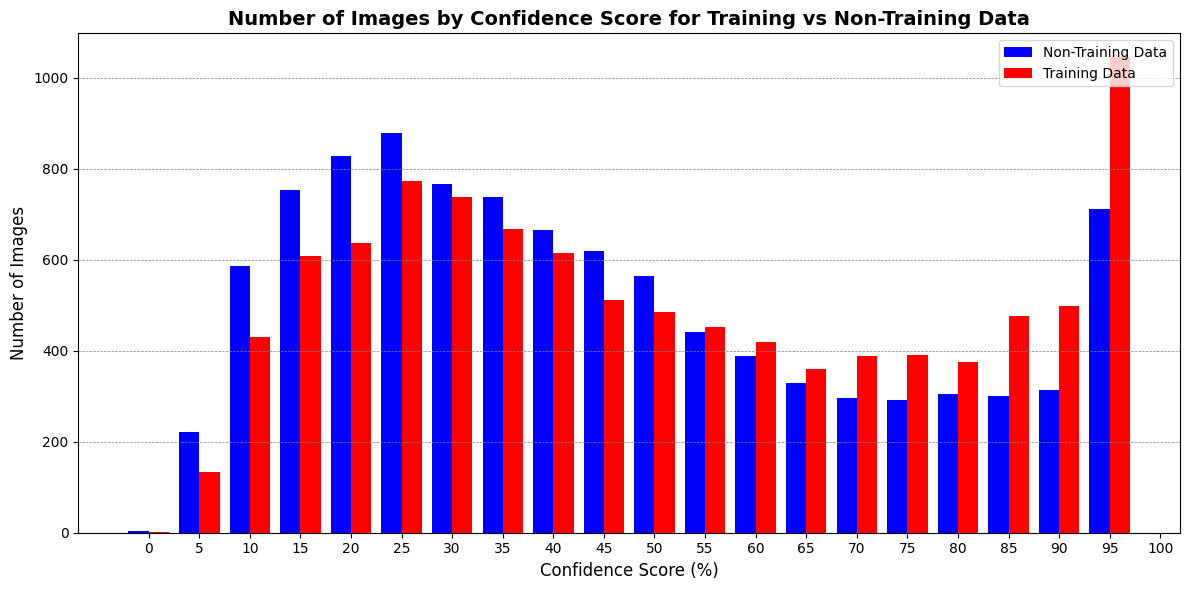

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities for each class in the combined test set
probabilities = model.predict(combined_test_images)

# Get the highest confidence score for each image
max_confidences = np.max(probabilities, axis=1) * 100  # Convert to percentage

# Separate confidence scores based on membership flag
training_confidences = max_confidences[membership_flag == 1]
non_training_confidences = max_confidences[membership_flag == 0]

# Define confidence bins for the x-axis
confidence_bins = np.arange(0, 101, 5)  # Bins from 0 to 100% in steps of 5%

# Calculate histogram (count) of confidence scores for each group
training_counts, _ = np.histogram(training_confidences, bins=confidence_bins)
non_training_counts, _ = np.histogram(non_training_confidences, bins=confidence_bins)

# Plotting the bar graph
plt.figure(figsize=(12, 6))
width = 2  # Width of each bar

# Bar plot for non-training (original test set) data
plt.bar(confidence_bins[:-1] - width/2, non_training_counts, width=width, color='blue', label='Non-Training Data')

# Bar plot for training data
plt.bar(confidence_bins[:-1] + width/2, training_counts, width=width, color='red', label='Training Data')

# Labeling the plot
plt.xlabel('Confidence Score (%)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images by Confidence Score for Training vs Non-Training Data', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.xticks(confidence_bins, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Set a threshold for confidence (e.g., 90%)
confidence_threshold = 99

# Find data points above and below the threshold
above_threshold = max_confidences >= confidence_threshold
below_threshold = max_confidences < confidence_threshold

# Split based on membership flag
above_threshold_training = np.sum(above_threshold & (membership_flag == 1))
above_threshold_non_training = np.sum(above_threshold & (membership_flag == 0))

below_threshold_training = np.sum(below_threshold & (membership_flag == 1))
below_threshold_non_training = np.sum(below_threshold & (membership_flag == 0))

# Print out the results
print(f"Training images above {confidence_threshold}%: {above_threshold_training}")
print(f"Non-training images above {confidence_threshold}%: {above_threshold_non_training}")
print(f"Training images below {confidence_threshold}%: {below_threshold_training}")
print(f"Non-training images below {confidence_threshold}%: {below_threshold_non_training}")

Training images above 99%: 335
Non-training images above 99%: 268
Training images below 99%: 9665
Non-training images below 99%: 9732


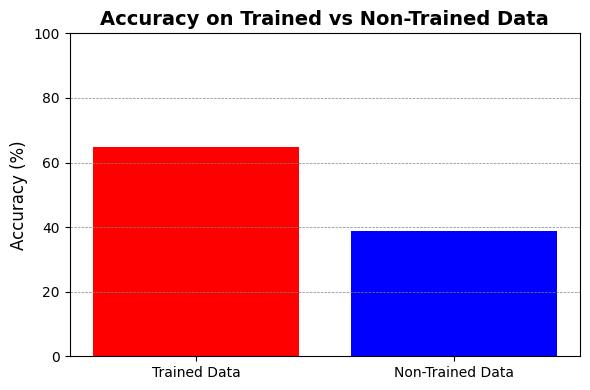

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predicted classes
predictions = np.argmax(probabilities, axis=1)

# Convert one-hot encoded labels back to class integers

true_labels = np.argmax(combined_test_labels, axis=1)

# Separate indices based on membership
train_indices = (membership_flag == 1)
non_train_indices = (membership_flag == 0)

# Calculate accuracy for training-member images
train_accuracy = np.mean(predictions[train_indices] == true_labels[train_indices])

# Calculate accuracy for non-training-member images
non_train_accuracy = np.mean(predictions[non_train_indices] == true_labels[non_train_indices])

# Plot accuracies as a bar chart
plt.figure(figsize=(6,4))
plt.bar(['Trained Data', 'Non-Trained Data'], [train_accuracy*100, non_train_accuracy*100], color=['red', 'blue'])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy on Trained vs Non-Trained Data', fontsize=14, weight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Get predicted classes
predictions = np.argmax(probabilities, axis=1)

# Convert one-hot encoded labels back to class integers
true_labels = np.argmax(combined_test_labels, axis=1)

# Separate indices based on membership
train_indices = (membership_flag == 1)
non_train_indices = (membership_flag == 0)

# Calculate accuracy for training-member images
train_accuracy = np.mean(predictions[train_indices] == true_labels[train_indices]) * 100

# Calculate accuracy for non-training-member images
non_train_accuracy = np.mean(predictions[non_train_indices] == true_labels[non_train_indices]) * 100

# Print the accuracies
print(f"Accuracy on Trained Data: {train_accuracy:.2f}%")
print(f"Accuracy on Non-Trained Data: {non_train_accuracy:.2f}%")


Accuracy on Trained Data: 62.92%
Accuracy on Non-Trained Data: 38.02%
